In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [ ]:
random_seed = 11

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True # 고정하면 학습이 느려진다고 합니다.
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [4]:
# train_dir = '/opt/ml/input/data/train'

In [5]:
imgdf = pd.read_csv("../input/data/train/images_new.csv")
imgdf

,path,label
0,../input/data/train/images/000001_female_Asian...,4
1,../input/data/train/images/000001_female_Asian...,4
2,../input/data/train/images/000001_female_Asian...,16
3,../input/data/train/images/000001_female_Asian...,4
4,../input/data/train/images/000001_female_Asian...,4
...,...,...
18895,../input/data/train/images/006959_male_Asian_1...,12
18896,../input/data/train/images/006959_male_Asian_1...,0
18897,../input/data/train/images/006959_male_Asian_1...,0
18898,../input/data/train/images/006959_male_Asian_1...,6


In [6]:
# 이미지 시각화를 위한 코드
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
imgdf.path.iloc[0]

'../input/data/train/images/000001_female_Asian_45/mask5.jpg'

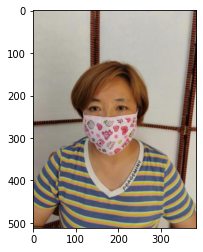

In [8]:
plt.imshow(Image.open(imgdf.path.iloc[0]))

In [9]:
imgdf.label.iloc[0]

4

In [10]:
class DatasetForMask(Dataset):
    def __init__(self, img_paths, transform):
        self.X = img_paths["path"]
        self.y = img_paths["label"]
        self.transform = transform
    
    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.X)


In [11]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

In [12]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(imgdf, test_size=0.2, stratify = imgdf["label"], random_state=11)

In [13]:
train.label.value_counts()

4     3268
3     2928
0     2196
1     1640
10     654
16     654
9      586
15     586
6      439
12     439
5      436
2      332
13     328
7      328
11      87
17      87
14      66
8       66
Name: label, dtype: int64

In [14]:
valid.label.value_counts()

4     817
3     732
0     549
1     410
10    163
16    163
9     146
15    146
12    110
6     110
5     109
2      83
7      82
13     82
11     22
17     22
14     17
8      17
Name: label, dtype: int64

In [15]:
BATCH_SIZE = 64

In [16]:
train_dataset = DatasetForMask(train, transform)
train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True
                             )

In [17]:
valid_dataset = DatasetForMask(valid, transform)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True
                             )

In [18]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

In [19]:
# ImageNet에서 학습된 ResNet 18 딥러닝 모델을 불러옴
imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)
print("네트워크 필요 입력 채널 개수", imagenet_resnet18.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", imagenet_resnet18.fc.weight.shape[0])
print(imagenet_resnet18)

네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 1000
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [20]:
import math
## 1. 분류 모델의 output 크기가 1000개로 되어 있음으로 mnist data class 개수로 나올 수 있도록 Fully Connected Layer를 변경하고 xavier uniform으로 weight 초기화
MASK_CLASS_NUM = 18
imagenet_resnet18.fc = torch.nn.Linear(in_features=512, out_features=MASK_CLASS_NUM, bias=True)
torch.nn.init.xavier_uniform_(imagenet_resnet18.fc.weight)
stdv = 1. / math.sqrt(imagenet_resnet18.fc.weight.size(1))
imagenet_resnet18.fc.bias.data.uniform_(-stdv, stdv)

print("네트워크 필요 입력 채널 개수", imagenet_resnet18.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", imagenet_resnet18.fc.weight.shape[0])

네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 18


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 학습 때 GPU 사용여부 결정. Colab에서는 "런타임"->"런타임 유형 변경"에서 "GPU"를 선택할 수 있음

print(f"{device} is using!")

imagenet_resnet18.to(device) # Resnent 18 네트워크의 Tensor들을 GPU에 올릴지 Memory에 올릴지 결정함

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 10 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(imagenet_resnet18.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

cuda:0 is using!


In [22]:
from tqdm import tqdm, notebook

In [ ]:
### 학습 코드 시작
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
  for phase in ["train", "test"]:
    running_loss = 0.
    running_acc = 0.
    if phase == "train":
      imagenet_resnet18.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
    elif phase == "test":
      imagenet_resnet18.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

    for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
      # (참고.해보기) 현재 tqdm으로 출력되는 것이 단순히 진행 상황 뿐인데 현재 epoch, running_loss와 running_acc을 출력하려면 어떻게 할 수 있는지 tqdm 문서를 보고 해봅시다!
      # hint - with, pbar
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

      with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
        logits = imagenet_resnet18(images)
        _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
        loss = loss_fn(logits, labels)

        if phase == "train":
          loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
          optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

      running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
      running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

    # 한 epoch이 모두 종료되었을 때,
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
    if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
      best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
      best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

  0%|          | 0/60 [00:00<?, ?it/s]

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.477, 평균 Accuracy : 0.859


  0%|          | 0/237 [00:00<?, ?it/s]

현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.176, 평균 Accuracy : 0.941


  0%|          | 0/60 [00:00<?, ?it/s]

현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.072, 평균 Accuracy : 0.981


  0%|          | 0/237 [00:00<?, ?it/s]

현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.102, 평균 Accuracy : 0.966


  0%|          | 0/60 [00:00<?, ?it/s]

현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.021, 평균 Accuracy : 0.997


  0%|          | 0/237 [00:00<?, ?it/s]

현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.055, 평균 Accuracy : 0.983


  0%|          | 0/60 [00:00<?, ?it/s]

현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.007, 평균 Accuracy : 1.000


  0%|          | 0/237 [00:00<?, ?it/s]

현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.084, 평균 Accuracy : 0.976


  3%|▎         | 7/237 [00:04<02:22,  1.62it/s]

In [ ]:
imagenet_resnet18()